# Explore cell type bias due to different growth rates in the clone distributions in the T-cell project

In [1]:
import os, sys
parent_dir = os.path.abspath('..')

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [3]:
import numpy as np
import anndata
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib

In [3]:
home = os.path.expanduser("~")
ADATA_PATH = # ENTER PATH TO FIRST BARCODED TCELL DATASET HERE

# Specify the starting and ending timepoints of interest
t1 = 5
t2 = 10
times = [t1, t2]

In [4]:
matplotlib.rcParams.update({'font.size': 16})
plt.style.use("plot_style.txt")

## Load the data

In [5]:
# Load data from the lineage barcoding experiment
adata = anndata.read_h5ad(ADATA_PATH)

# Reduce to just the data from t=t1 to t=t2
order_filter = adata.obs.index[adata.obs.Order.apply(lambda x: x in times)]

adata = adata[order_filter]

In [6]:
cell_types = list(adata.obs['Cell Types'].unique())
print(cell_types)

['Progenitor Cells', 'Myeloid Cells', 'Erythroid Cells', 'Mast Cells', 'Endothelial Cells', 'ProT Cells']


In [7]:
# Assign colors by cell type for plotting
celltype_color = {'Endothelial Cells': 'tab:green',
                  'Erythroid Cells': 'tab:red',
                  'Myeloid Cells': 'tab:orange',
                  'Mast Cells': 'xkcd:maroon',
                  'ProT Cells': 'tab:cyan',
                  'Progenitor Cells': 'tab:grey'}


# Create the legend for the color dictionary
def lineage_elem(lin, color_dict):
    return Line2D([0], [0], marker='o', color='w', label=lin, markerfacecolor=color_dict[lin], markersize=10)

celltype_legend_handles = [lineage_elem(lin, celltype_color) for lin in celltype_color.keys()]

## Estimate growth rates using gene signature scores

In [8]:
# Define logistic function to estimate birth/death rates from signature scores
def logistic(x, L, k, x0=0):
    f = L / (1 + np.exp(-k * (x - x0)))
    return f

def gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width):
    return beta_min + logistic(p, L=beta_max - beta_min, k=4 / width, x0=center)

def beta(p, beta_max=1.7, beta_min=0.3, pmax=1.0, pmin=-0.5, center=0.25):
    return gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width=0.5)

def delta(a, delta_max=1.7, delta_min=0.3, amax=0.5, amin=-0.4, center=0.1):
    return gen_logistic(a, delta_max, delta_min, amax, amin, center,
                          width=0.2)

In [9]:
# Calculate birth/death rates by cell
birth = beta(adata.obs['G2M'])
death = delta(adata.obs['Apoptosis'])

# Calculate the growth 
adata.obs['growth'] = np.exp(birth-death)

/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


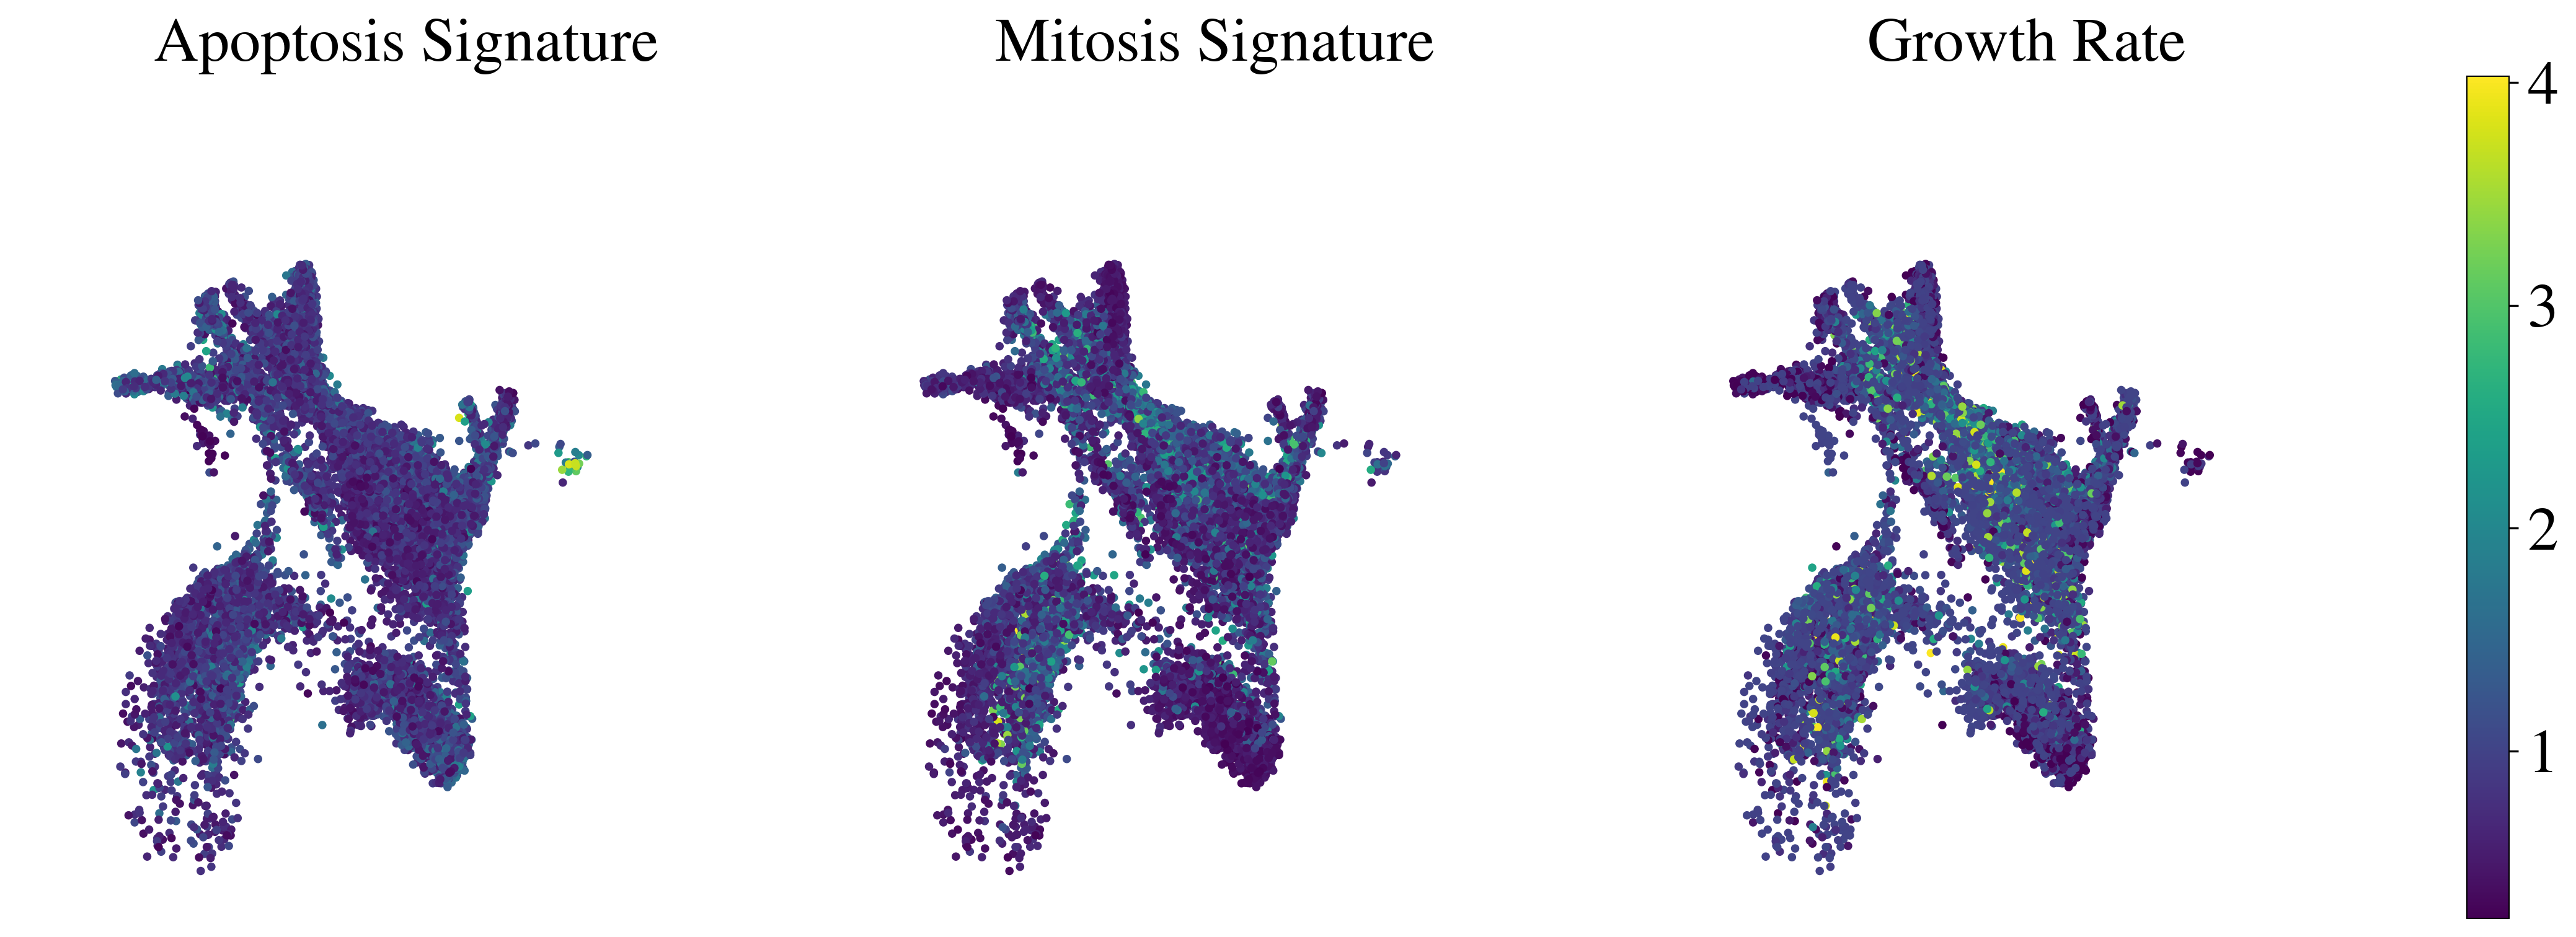

In [10]:
# Plot the growth rates compared to the two signatures
fig = plt.figure(figsize=(18,6))
gs= fig.add_gridspec(1,13)
plt.subplot(gs[0, :4])
plt.title('Apoptosis Signature')
plt.axis('off')
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], c=adata.obs['Apoptosis'], s=6)

plt.subplot(gs[0, 4:8])    
plt.title('Mitosis Signature')
plt.axis('off')
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], c=adata.obs['G2M'], s=6)

plt.subplot(gs[0, 8:])
plt.title('Growth Rate')
plt.axis('off')
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], c=adata.obs['growth'], s=6)
plt.colorbar()
plt.show()

In [11]:
# Compute the mean growth rate for each cell type between the two timepoints of interest
normalize = False
growth_rates = np.zeros((len(times), len(cell_types)))
growth_rates_sd = np.zeros((len(times), len(cell_types)))
for i in range(len(times)):
    for j in range(len(cell_types)):
        t = times[i]
        c = cell_types[j]
        cells_in_c_at_t = adata[(adata.obs['Order'] == t) & (adata.obs['Cell Types'] == c)]
        
        growth_t1_t2 = cells_in_c_at_t.obs['growth'].pow(t2-t1)
        
        growth_rates[i, j] = growth_t1_t2.mean()
        growth_rates_sd[i, j] = growth_t1_t2.std()
        
    if normalize:
        growth_rates[i] /= np.sum(growth_rates[i])

growth_rates_adata = anndata.AnnData(X=growth_rates, obs={'Order': times}, var={'Cell Types': cell_types})
growth_rates_adata.obs.set_index('Order', inplace=True)
growth_rates_adata.var.set_index('Cell Types', inplace=True)

growth_rates_df = growth_rates_adata.to_df()

growth_rates_sd_adata = anndata.AnnData(X=growth_rates_sd, obs={'Order': times}, var={'Cell Types': cell_types})
growth_rates_sd_adata.obs.set_index('Order', inplace=True)
growth_rates_sd_adata.var.set_index('Cell Types', inplace=True)

growth_rates_sd_df = growth_rates_sd_adata.to_df()

/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [12]:
growth_rates_df

Cell Types,Progenitor Cells,Myeloid Cells,Erythroid Cells,Mast Cells,Endothelial Cells,ProT Cells
Order,,,,,,
5,49.157299,38.075890,6.791887,75.807045,0.59513,1032.968628
10,2.245908,11.124754,10.508393,6.108720,NaN,22.981155


In [13]:
growth_rates_sd_df

Cell Types,Progenitor Cells,Myeloid Cells,Erythroid Cells,Mast Cells,Endothelial Cells,ProT Cells
Order,,,,,,
5,148.700668,128.485031,36.923611,187.691360,1.785196,NaN
10,15.634150,65.614365,78.939713,53.261749,NaN,106.994194


## Compute the observed cell type distributions

In [14]:
# Print the number of clones, multi-cell clones and multi-time clones
print("Number of clones = ", adata.obsm['X_clone'].shape[1])

# Filter to retain only clones which contain at least 2 cells
# (clones with only one cell contribute no lineage information)
clones_filtered = []
clones_filtered_t1 = []
clones_filtered_t2 = []
clones_filtered_multitime = []
for b in range(adata.obsm['X_clone'].shape[1]):
    cell_indicies_with_b = adata.obsm['X_clone'][:,b].nonzero()[0]
    if cell_indicies_with_b.shape[0] > 1:
        clones_filtered.append(b)
        
        times_b = set(adata[cell_indicies_with_b].obs['Order'])
        if t1 in times_b:
            cell_indicies_with_b_t1 = adata[adata.obs.Order == t1].obsm['X_clone'][:,b].nonzero()[0]
            if len(cell_indicies_with_b_t1) > 1: # multiple cells in clone at t=t1
                clones_filtered_t1.append(b)
            
        if t2 in times_b:
            cell_indicies_with_b_t2 = adata[adata.obs.Order == t2].obsm['X_clone'][:,b].nonzero()[0]
            if len(cell_indicies_with_b_t2) > 1: # multiple cells in clone at t=t2
                clones_filtered_t2.append(b)
        
        if len(times_b) > 1:
            clones_filtered_multitime.append(b)
            
        
print("Number of clones containing more than one cell = ", len(clones_filtered))
print("Number of clones appearing at both timepoints = ", len(clones_filtered_multitime))

Number of clones =  1465
Number of clones containing more than one cell =  1356
Number of clones appearing at both timepoints =  268


In [15]:
clones_filtered_single_time = set(clones_filtered_t1).union(set(clones_filtered_t2))

In [16]:
# Extract the subset with just the clones
index_w_clones = list(set(adata.obsm['X_clone'].nonzero()[0]))
clone_filter = adata.obs.index[index_w_clones]
adata_clones = adata[clone_filter]

# Extract the subset with just the clones shared by more than one cell
index_w_multicell_clones = list(set(adata.obsm['X_clone'][:, clones_filtered].nonzero()[0]))
multicell_clone_filter = adata.obs.index[index_w_multicell_clones]
adata_clones_multicell = adata_clones[multicell_clone_filter]

# Extract the subset with just the clones shared by more than one cell at multiple timepoints
index_w_multitime_clones = list(set(adata.obsm['X_clone'][:, clones_filtered_multitime].nonzero()[0]))
multitime_clone_filter = adata.obs.index[index_w_multitime_clones]
adata_clones_multitime = adata_clones_multicell[multitime_clone_filter]

# Extract the subset in just single time clones
index_w_singletime_clones = list(set(adata.obsm['X_clone'][:, list(clones_filtered_single_time)].nonzero()[0]))
singletime_clone_filter = adata.obs.index[index_w_singletime_clones]
adata_clones_singletime = adata_clones[singletime_clone_filter]

In [17]:
# Sampling parameters inherent to the dataset
r = {str(t1): 7951/26500, str(t2): 4691/232400}
b = {str(t1): 2189/7951, str(t2): 1784/4691}
rb = {}
rb[str(t1)] = r[str(t1)]*b[str(t1)]
rb[str(t2)] = r[str(t2)]*b[str(t2)]

print("From experimental dataset: \n")
print("\t sampling rate, r =", r)
print("\t combined barcoding and barcode detection rate, b =", b)
print("\t combined sampling rate, rb =", rb)

From experimental dataset: 

	 sampling rate, r = {'5': 0.30003773584905663, '10': 0.02018502581755594}
	 combined barcoding and barcode detection rate, b = {'5': 0.2753112815997988, '10': 0.3803027073118738}
	 combined sampling rate, rb = {'5': 0.08260377358490567, '10': 0.007676419965576593}


In [18]:
# Add the sampling rates to the anndata object
adata.obs['rb'] = adata.obs.Order.apply(lambda x: rb[str(x)])

In [19]:
# Create a cell census dataframe for the two timepoints for the entire population, just the multicell clones
# and just the multitime clones
normalized = True
census_df = pd.DataFrame({'Endothelial Cells': [],'Erythroid Cells': [],'Myeloid Cells': [],
                          'Mast Cells': [],'ProT Cells': [], 'Progenitor Cells': []})
population_adatas = {
#     "total - LBC + timecourse": adata, 
                     "Total sample": adata[adata.obs.dataset != 'timecourse'],
                     "Barcode detected": adata_clones_singletime,
                     "Multi-cell": adata_clones_multicell,
                     "Multi-time": adata_clones_multitime}
census_dfs = dict(zip(population_adatas.keys(), [census_df, census_df, census_df, census_df]))                     


for k in population_adatas:
    for t in [t1, t2]:
        data = population_adatas[k].obs[population_adatas[k].obs.Order == t]
        if normalized:
            census_dfs[k] = census_dfs[k].append({'Order': t, 
                                          'Endothelial Cells': data[data['Cell Types'] == 'Endothelial Cells'].shape[0]/data.shape[0], 
                                          'Erythroid Cells': data[data['Cell Types'] == 'Erythroid Cells'].shape[0]/data.shape[0], 
                                          'Myeloid Cells': data[data['Cell Types'] == 'Myeloid Cells'].shape[0]/data.shape[0],
                                          'Mast Cells': data[data['Cell Types'] == 'Mast Cells'].shape[0]/data.shape[0], 
                                          'ProT Cells': data[data['Cell Types'] == 'ProT Cells'].shape[0]/data.shape[0], 
                                          'Progenitor Cells': data[data['Cell Types'] == 'Progenitor Cells'].shape[0]/data.shape[0]},
                                        ignore_index = True)
        else:
            census_dfs[k] = census_dfs[k].append({'Order': t, 
                                          'Endothelial Cells': data[data['Cell Types'] == 'Endothelial Cells'].shape[0], 
                                          'Erythroid Cells': data[data['Cell Types'] == 'Erythroid Cells'].shape[0], 
                                          'Myeloid Cells': data[data['Cell Types'] == 'Myeloid Cells'].shape[0],
                                          'Mast Cells': data[data['Cell Types'] == 'Mast Cells'].shape[0], 
                                          'ProT Cells': data[data['Cell Types'] == 'ProT Cells'].shape[0], 
                                          'Progenitor Cells': data[data['Cell Types'] == 'Progenitor Cells'].shape[0]},
                                        ignore_index = True)
            

    census_dfs[k] = census_dfs[k].set_index('Order')
    print("\n CELL CENSUS: {}".format(k))
    print(census_dfs[k].to_string())


 CELL CENSUS: Total sample
       Endothelial Cells  Erythroid Cells  Myeloid Cells  Mast Cells  ProT Cells  Progenitor Cells
Order                                                                                             
5.0             0.004532         0.061304       0.290660    0.008812    0.000126          0.634567
10.0            0.000000         0.027884       0.260962    0.302895    0.369519          0.038740

 CELL CENSUS: Barcode detected
       Endothelial Cells  Erythroid Cells  Myeloid Cells  Mast Cells  ProT Cells  Progenitor Cells
Order                                                                                             
5.0             0.000982         0.069710       0.375552    0.009818    0.000000          0.543937
10.0            0.000000         0.029803       0.291693    0.261890    0.395054          0.021560

 CELL CENSUS: Multi-cell
       Endothelial Cells  Erythroid Cells  Myeloid Cells  Mast Cells  ProT Cells  Progenitor Cells
Order                  

In [20]:
# Print the total number of cells in each group as a dataframe
n_cell_df = pd.DataFrame(dict(zip(
    population_adatas.keys(), [[] for i in range(len(population_adatas.keys()))])))
n_cell_df.insert(0, 'Order', [])
n_cell_df = n_cell_df.set_index('Order')

for t in [t1, t2]:
    row = []
    for k in population_adatas:
        data = population_adatas[k][population_adatas[k].obs.Order == t]
        n_cells = data.n_obs
        row.append(int(n_cells))
    n_cell_df.loc[int(t)] = row
    
n_cell_df

,Total sample,Barcode detected,Multi-cell,Multi-time
Order,,,,
5,7944.0,2037.0,2157.0,369.0
10,4698.0,1577.0,1697.0,462.0


In [21]:
census_dfs_as_df = pd.concat(census_dfs)

In [22]:
one, two = census_dfs_as_df.groupby("Order")

In [23]:
census_dfs_t1 = one[1].droplevel(1)
census_dfs_t2 = two[1].droplevel(1)
census_dfs_by_time = {str(t1): census_dfs_t1, str(t2): census_dfs_t2}

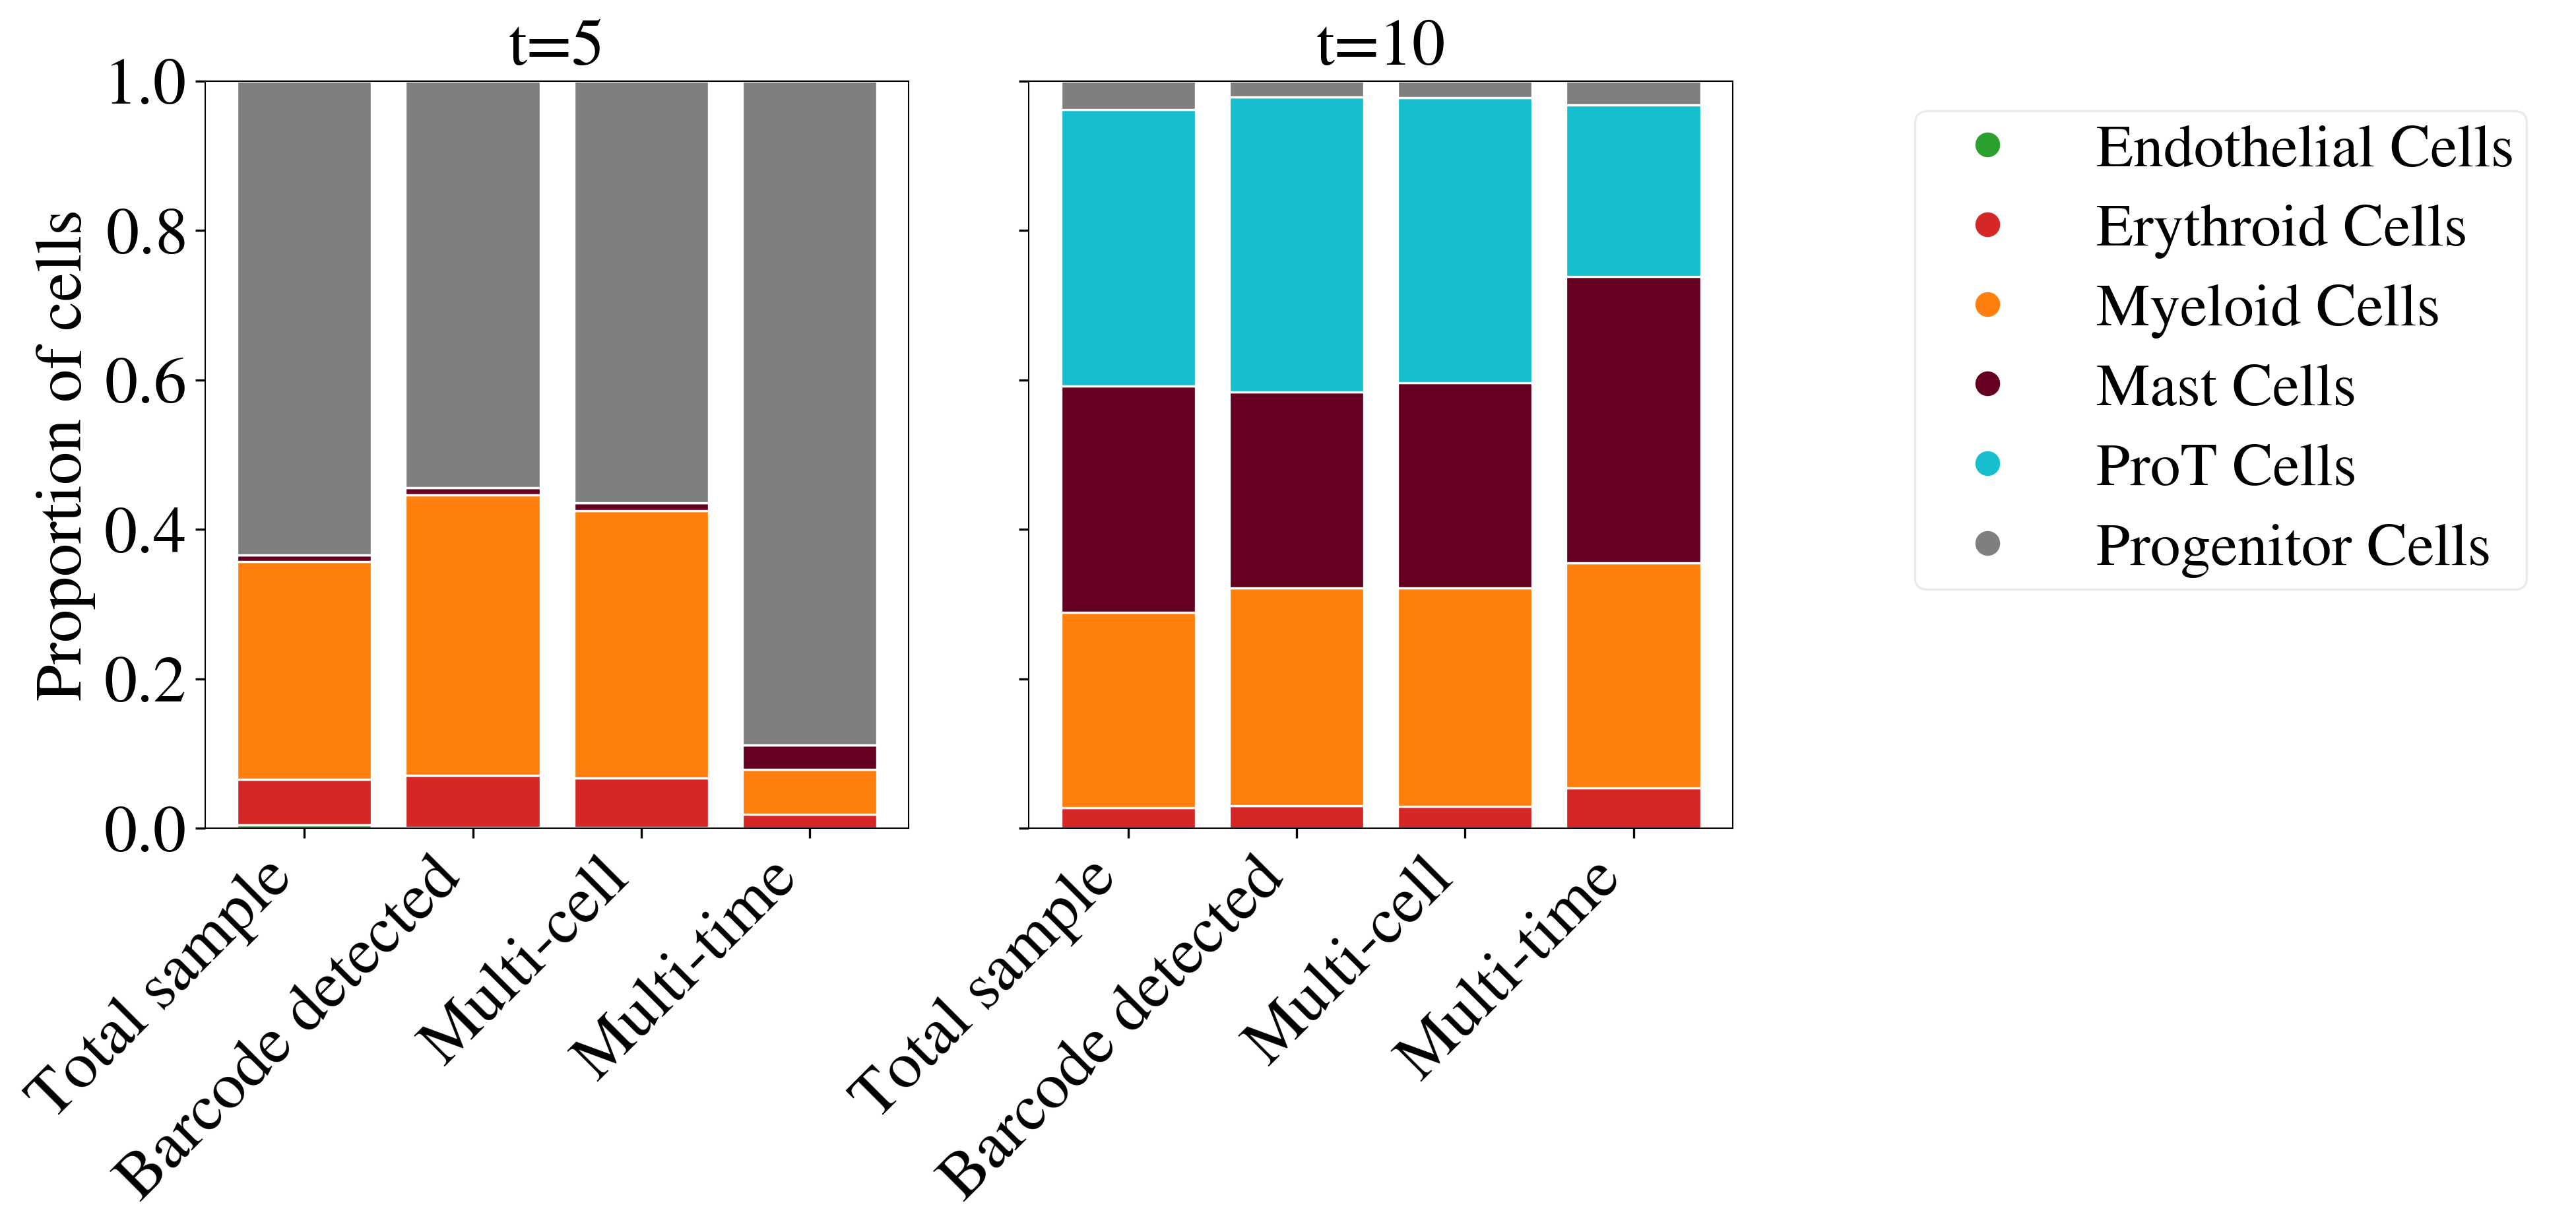

In [24]:
# Compare the cell censuses visually, grouping by timepoint
fig = plt.figure(figsize=(16,5))
# plt.suptitle("Cell Census", fontweight='bold')
fig.tight_layout()
gs = fig.add_gridspec(1, 24)

n_subsets = len(census_dfs.keys())

i = 1
for t in [t1, t2]:
    plt.subplot(gs[:, 8*(i-1):8*i - 1])
    plt.title(f"t={t}")
    plt.ylim(0, 1.0)
        
    # Just plot axis label once
    if i == 1:
        plt.ylabel('Proportion of cells')
    else:
        yticks, _ = plt.yticks()
        plt.yticks(yticks, labels=["" for i in yticks])
    
    data = census_dfs_by_time[str(t)]
    data = data.divide(data.sum(axis=1), axis="rows")
    
    # Plot the cell census
    plt.xticks(range(n_subsets), data.index.get_level_values(0), rotation=45, ha="right")

    baseline = np.zeros(n_subsets)
    for lin in data.columns:
        plt.bar(range(4), data[lin], facecolor=celltype_color[lin], edgecolor='w', label=lin, bottom=baseline)
        baseline = baseline + data[lin]

    i += 1

# Plot the legend
plt.subplot(gs[:, -2])
plt.axis('off')
plt.legend(handles=celltype_legend_handles, frameon=True, fontsize=22)

plt.show()